In [6]:
%matplotlib widget
from vpython import *
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import proxsuite
from qpsolvers import solve_qp

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="vpython")

# **3. Control via QP**

The task for this subproblem is to use your QP solver (developed in Sec. 2) to make the body
of the system follow **sinusoidal trajectories** in both x and y. You can define any sinusoidal
trajectory: be creative and create a nice little dance routine. **The initial state of the system should be**  $x_0 = [0\,\,\,1\,\,\,0\,\,\,0]^T$. You are allowed to use only the native Python and the numpy library.

In [7]:
# Parameters
g = 9.81   # gravity
m = 5.     # mass
dt = 0.04  # timestep

# Generate a random non-trivial quadratic program.
n = 4 # number of dimensions of the optimization variables (x)
p = 2 # number of equality constraints

# Random Cost
Q1 = 0.8 * np.eye(2)
Q2 = 0.001 * np.eye(2)
z = np.zeros((int(n/2), int(n/2)))
Q = np.block([[Q1,  z],
              [ z, Q2]])

In [8]:
def dynamics(x, u):
    x, y, x_dot, y_dot = x[0,0], x[1,0], x[2,0], x[3,0]

    rx = x/np.sqrt(x**2 + y**2)
    ry = y/np.sqrt(x**2 + y**2)
    r = np.array([[rx], [ry]])
    
    x_ddot = (rx*u[0,0] - ry*u[1,0])/m
    y_ddot = (ry*u[0,0] + rx*u[1,0])/m - g
    f = np.array([[x_dot, y_dot, x_ddot, y_ddot]]).T

    return f

In [9]:
# Runge-Kutta 4th Order integration
def rk4(x, u):
    f1 = dynamics(x,u)
    f2 = dynamics(x + f1 * dt/2,u)
    f3 = dynamics(x + f2 * dt/2,u)
    f4 = dynamics(x + f3 * dt,u)
    
    return x + dt/6 * (f1 + 2*f2 + 2*f3 + f4)

In [10]:
def eq_constr(x):
    x, y = x[0,0], x[1,0]
    
    rx = x/np.sqrt(x**2 + y**2)
    ry = y/np.sqrt(x**2 + y**2)

    A = np.array([[1., 0., -rx/m,  ry/m],
                  [0., 1., -ry/m, -rx/m]])
    b = np.array([[0., -g]]).T
    
    return A, b

In [11]:
# Optimization function
def f(z, Q, q):
    return (1/2) * z.T @ Q @ z + q.T @ z

# Projection onto the nonnegative orthant
def projection_nonnegative(a):
    return np.maximum(a, 0)

# Residuals and Stationarity Computation
def compute_residuals_stationarity(Q, q, A, b, z, lamda):
    eq_res = np.linalg.norm(A @ z - b, np.inf)
    stat = np.linalg.norm(Q @ z + q + A.T @ lamda, np.inf)

    return eq_res, stat

In [12]:
# Primal-Dual Augmented Lagrangian Method (problem with equality constraints only)
def pd_ALM(Q, q, A, b, z, rho = 0.1, eps_feas = 1e-6, eps_stat = 1e-6): 
    lamda = np.zeros(p).reshape(p,1) # λ0
    tau = 10.                        # τ0
        
    best_feas = np.inf
    max_iterations = 100
    counter = 0

    for i in range(max_iterations):
        lhs_matrix = Q + rho * (A.T @ A)
        rhs_matrix = - q - A.T @ (lamda - rho * b)
        
        # (x,λ) update
        z = np.linalg.solve(lhs_matrix, rhs_matrix)
        lamda += rho * (A @ z - b)

        # Residuals and Stationarity Computation
        eq_res, stat = compute_residuals_stationarity(Q, q, A, b, z, lamda)
        
        if ((eq_res < eps_feas) and (stat < eps_stat)):
            break

        if (eq_res < best_feas):
            best_feas = eq_res
            counter = 0
        else:
            counter += 1

        if (counter >= 2):
            rho *= tau  # increase penalty
        
    return z

In [13]:
# Visualization of Hopper Robot
def visualization(x, y, traj_name):
    global scene, pivot, mass, rod
    
    scene = canvas(resizable=False, userzoom=False, userspin=False)
    scene.title = "Hopper Robot Vizualization"
    scene.width = 1280
    scene.height = 960
    
    scene.background = color.white # background color
    scene.center = vector(0, 0, 0) # background center
    
    scene.range = 0.8
    scene.camera.pos = vector(0, 0, 2)   # camera's position
    scene.camera.axis = vector(0, 0, -2) # camera's axis
    
    # Ground
    ground = box(pos=vector(0, 0, 0), size=vector(1.5, 0.05, 0.7), color=color.gray(0.7))
    pivot = sphere(pos=vector(0, 0.05, 0), radius=0.02, color=color.black)
    
    # Hopper robot
    if(traj_name == 'simple'):
        mass = sphere(pos=vector(x, y, 0), radius=0.05, color=color.red, retain=200, make_trail=True, trail_color=color.green, trail_radius=0.002)
    elif(traj_name == 'heart'):
        mass = sphere(pos=vector(x, y, 0), radius=0.05, color=color.red, retain=200, make_trail=True, trail_color=color.red, trail_radius=0.002)
    elif(traj_name == 'flower'):
        mass = sphere(pos=vector(x, y, 0), radius=0.05, color=color.red, retain=200, make_trail=True, trail_color=color.yellow, trail_radius=0.002)
        
    rod = cylinder(pos=pivot.pos, axis=mass.pos - pivot.pos, radius=0.005, color=color.blue)

def visualization_update(x, y, traj_name):
    global mass, rod

    rod.pos = pivot.pos
    rod.axis = mass.pos - pivot.pos
    mass.pos = vector(x, y, 0)

    if(traj_name == 'simple'):
        sphere(pos=mass.pos, radius=0.005, color=color.green)
    elif(traj_name == 'heart'):
        sphere(pos=mass.pos, radius=0.005, color=color.red)
    elif(traj_name == 'flower'):
        sphere(pos=mass.pos, radius=0.005, color=color.yellow)

In [14]:
def choose_trajectory(name, t):
    # Amplitude, frequency and angular velocity for desired trajectory
    Ax, Ay = 0.4, 0.3
    freq = 0.3
    wx, wy = 2*np.pi*freq, 2*np.pi*freq

    if(name == 'simple'):
        # Trajectory 1: sinusoidal motion on the vertical axis
        x = 0.5
        y = 0.4 + 0.2 * np.sin(t)

        x_dot = 0.
        y_dot = 0.2 * np.cos(t)

        x_ddot = 0.
        y_ddot = -0.2 * np.sin(t)
    elif(name == 'heart'):
        # Trajectory 2: heart-dance
        x = Ax * np.sin(t)**3
        y = Ay * (0.9 * np.cos(t) - 0.4 * np.cos(2 * t) - 0.15 * np.cos(3 * t) - 0.05 * np.cos(4 * t)) + 0.6
        
        x_dot = Ax * 3 * np.sin(t)**2 * np.cos(t)
        y_dot = Ay * (-0.9 * np.sin(t) + 0.8 * np.sin(2 * t) + 0.45 * np.sin(3 * t) + 0.2 * np.sin(4 * t))
        
        x_ddot = Ax * 3 * (2 * np.sin(t) * np.cos(t)**2 - np.sin(t)**3)
        y_ddot = Ay * (-0.9 * np.cos(t) + 1.6 * np.cos(2 * t) + 1.35 * np.cos(3 * t) + 0.8 * np.cos(4 * t))
    elif(name == 'flower'): 
        # Trajectory 3: flower-dance
        Ax, Ay = 0.3, 0.3
        R, a, k = 1., 0.5, 6. # R: radius, a: sharpness of petals, k: number of petals
        
        r = R * (1 + a * np.cos(k * t))
        r_dot = -R * a * k * np.sin(k * t)
        r_ddot = -R * a * k**2 * np.cos(k * t)
        
        x = Ax * r * np.cos(t)
        y = Ay * r * np.sin(t)
        
        x_dot = Ax * (r_dot * np.cos(t) - r * np.sin(t))
        y_dot = Ay * (r_dot * np.sin(t) + r * np.cos(t)) + 1.2
        
        x_ddot = Ax * (r_ddot * np.cos(t) - 2 * r_dot * np.sin(t) - r * np.cos(t))
        y_ddot = Ay * (r_ddot * np.sin(t) + 2 * r_dot * np.cos(t) - r * np.sin(t))

    desired_x = np.array([[x, y, x_dot, y_dot]]).T
    feedforward = np.array([[x_ddot, y_ddot]]).T
    
    return desired_x, feedforward

Choose one of the following trajectories:
1. simple
2. heart
3. flower
Answer (full-name):  heart


<IPython.core.display.Javascript object>


         (last) optimal x: [-0.79329498 -0.28954649 47.76563539 -0.39051302]
[proxqp] (last) optimal x: [-0.79329498 -0.28954651 47.76563923 -0.39051305]



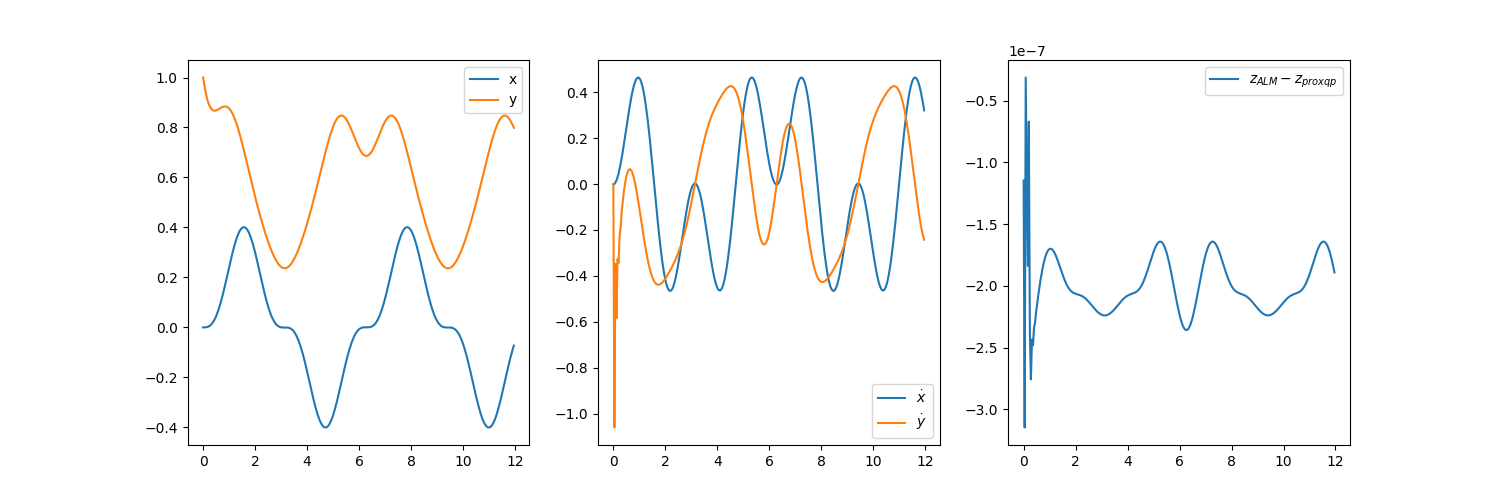

In [15]:
traj_name = input("Choose one of the following trajectories:\n1. simple\n2. heart\n3. flower\nAnswer (full-name): ")

# Initial state ([x, y, x_dot, y_dot])
x = np.array([[0., 1., 0., 0.]]).T

# Optimization variables ([x_ddot, y_ddot, f, τ])
z = np.array([[0., 0., 0., 0.]]).T

# Reference control
desired_u = np.array([[0., 0.]]).T

xs = []   # states
diff = [] # difference between z of ALM and proqp solver 

visualization(x[0,0], x[1,0], traj_name)

t = 0.
kp = 90.
kd = 40.
for i in range(300):
    rate(30)

    visualization_update(x[0,0], x[1,0], traj_name)
    xs.append(np.copy(x))

    desired_x, feedforward = choose_trajectory(traj_name, t)
    feedback = kp * (desired_x[:2, 0].reshape(2,1) - x[:2,0].reshape(2,1)) + kd * (desired_x[2:, 0].reshape(2,1) - x[2:,0].reshape(2,1))
    desired_a = feedforward + feedback
 
    # Cost
    q = np.concatenate([-Q1 @ desired_a, -Q2 @ desired_u])

    # Equality constraints
    A, b = eq_constr(x)
    
    # Optimal solution
    z = pd_ALM(Q, q, A, b, z)
    u = z[2:,0].reshape(2,1)

    # Integration
    x = rk4(x, u)
    
    if (x[1,0] < 0.12):
        x[1,0] = 0.12

    diff.append(np.copy(f((z.T)[0], Q, q) - f(solve_qp(P=Q, q=q, A=A, b=b, solver="proxqp"), Q, q)))

    t += dt

print(f"\n         (last) optimal x: {(z.T)[0]}")
print(f"[proxqp] (last) optimal x: {solve_qp(P=Q, q=q, A=A, b=b, solver="proxqp")}\n")
    
# Let's plot it!
xs = np.array(xs)
diff = np.array(diff)

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(131)

ax1.plot([n*dt for n in range(len(xs))], xs[:,0], label=r'x')
ax1.plot([n*dt for n in range(len(xs))], xs[:,1], label=r'y')
ax1.legend()

ax2 = fig.add_subplot(132)

ax2.plot([n*dt for n in range(len(xs))], xs[:,2], label=r'$\dot{x}$')
ax2.plot([n*dt for n in range(len(xs))], xs[:,3], label=r'$\dot{y}$')
ax2.legend()

ax3 = fig.add_subplot(133)

ax3.plot([n*dt for n in range(len(diff))], diff[:], label=r'$z_{ALM} - z_{proxqp}$')
ax3.legend()

plt.show()